<h1> <b>Title</b> Classification of sensory neurons based the calcium response </h1>

In [ ]:
# First, imported plot libraries
%matplotlib inline
import collections
from collections import Counter
from itertools import cycle
import numpy as np  # linear algebra
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
from scipy import interp

import plotly
import plotly.io as pio

pio.renderers.default = 'notebook'
# pio.renderers.default = 'colab'
import plotly.figure_factory as ff
import plotly.graph_objects as go

In [ ]:
# Then import machine learning libraries
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.manifold import Isomap, TSNE
from sklearn import svm, datasets
from sklearn.feature_selection import f_classif, RFE, SelectFromModel, SelectKBest
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold, learning_curve, RepeatedKFold
from sklearn.model_selection import ShuffleSplit, StratifiedKFold, StratifiedShuffleSplit, train_test_split
from sklearn.multiclass import OneVsRestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import LabelEncoder, label_binarize, OneHotEncoder, OrdinalEncoder
from imblearn.over_sampling import BorderlineSMOTE, SMOTE
from imblearn.metrics import classification_report_imbalanced
from imblearn.pipeline import make_pipeline as imbalanced_make_pipeline
from imblearn.under_sampling import NearMiss
from sklearn.neural_network import MLPClassifier

# Classifier libraries
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

# Neural netwrork classifier
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from keras.optimizers import Adam
import tensorflow as tf

import torch
import torch.nn as nn

# Other classifier
import xgboost as xgb
import warnings

warnings.filterwarnings('ignore')

# Introduction:
The nociceptive stimulus and injury induce responses in sensory neurons to produce physiological and pathological pain. The sensory neurons in the peripheral (DRG) comprises several subtypes of sensory neurons with different functions. These sensory neurons have been classified into distinct subtypes based on their cell-body diameters and gene expression patterns. <p> In order to indetify the modality-specific subsets of somatosensory neurons, in vivo imaging approach has been used with the advancement of the genetically encoded fluorescent calcium indicator GCaMP to study the activity of dorsal root ganglion sensory neurons in live animals. Here we use the in vivo imaging data to classify the sensory neurons ('small', 'large', 'medium) based their calcium response to different types of pain stimulus. First we ranked the feature importances with a forest of trees and fed the extracted features (3 out 9) based to logisitic regression (LC), random forest (RF), support vector machines (SVMs), extreme gradient boosting (XGBoost), and multilayer perceptron (MLP) classifiers as input.  Because the imbalance of the dataset, later we use oversampling to improve the performance and scalability of the classifiers. In our experiments, we use training and testing splitting (holdout method), and cross-validation (K-Fold) to measure the performance of the modeling results through the common confusion matrix rates such as accuracy, True-positive rate (TPR, or recall, sensitivity), True-negative rate (TNR, or specificity) and F1 Score. We used grid search to find the best parameters. The results show that RF and XGBoost has significantly higher accuracy and F1 Score than other models models.  

# Dataset:
We analyzed the dataset containing the feature vectors belonging to 839 cells. The dataset contains 10 features, one feature is categorical, other 9 features are numeric, we summarized the statistical characteristics of all the features below. We report the quantitative characteristics of the dataset for the numeric features. The dataset is highly imbalanced. Of the 839 cells in the dataset, 34.68 are from small-diameter sensory neurons, 56.02 are medium-sized, only 9.3 % are from large neurons. <p> Because class imbalance problem arises since the number of some class instances in the data set is much higher than that of the other class instances. Therefore, a balanced classifier is needed to increase accuracy of the production rate to the class with much less sample size in order to have a more <b> balanced dataset </b> and thus avoiding our models to overfitting.

## Summary of the dataset

In [ ]:
df = pd.read_csv('df_new.csv', index_col=0)
df = df[(df['V1'] > 1.3) | (df['V2'] > 1.3) | (df['V3'] > 1.3) |
        (df['V4'] > 1.3) | (df['V5'] > 1.3) | (df['V6'] > 1.3) |
        (df['V7'] > 1.3) | (df['V8'] > 1.3) | (df['V9'] > 1.3)]
df.head()

V1        V2        V3        V4        V5        V6        V7  \
cell                                                                           
510001  1.008010  0.947239  1.303464  1.103464  0.909373  1.227582  1.166134   
510002  0.629921  0.969547  1.133455  0.933455  1.183153  1.241237  1.214227   
510003  1.032310  0.942243  0.953919  0.994644  1.500366  1.573209  0.936047   
510004  0.484779  1.527135  1.423546  1.223546  0.258842  1.229355  0.784689   
510005  1.008726  0.666702  1.339037  1.139037  1.339623  1.337838  0.984082   

              V8        V9   class  
cell                                
510001  1.238667  1.815817  medium  
510002  0.719626  1.640061  medium  
510003  0.961773  1.598687   small  
510004  0.615348  2.320420  medium  
510005  1.475814  2.178210  medium

In [ ]:
df.describe()

V1          V2          V3          V4          V5          V6  \
count  839.000000  839.000000  839.000000  839.000000  839.000000  839.000000   
mean     1.067975    1.086807    1.153130    1.400375    1.922898    1.308838   
std      0.316163    0.569365    0.690950    1.371637    1.728734    0.513305   
min      0.239474    0.241734    0.117354   -0.082646    0.101495    0.346080   
25%      0.954926    0.932360    0.938820    0.793557    1.012834    1.097536   
50%      1.008726    1.011213    1.024326    0.970558    1.232633    1.232570   
75%      1.079437    1.105991    1.159077    1.291973    2.238023    1.443637   
max      3.772358   12.032041   14.473336   11.206221   17.890899    7.922439   

               V7          V8          V9  
count  839.000000  839.000000  839.000000  
mean     1.076853    1.077354    1.716993  
std      0.563383    0.481191    0.696811  
min      0.146234    0.105075    0.381463  
25%      0.919040    0.922601    1.310249  
50%      1.005383    1.016427    1.699515  
75%      1.100954    1.126974    1.835931  
max      8.716651    7.984241    9.412485

In [ ]:
df.columns

Index(['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'class'], dtype='object')

In [ ]:
# No null values!
df.isnull().sum().max()

0

In [ ]:
df['class'].value_counts()

medium    470
small     291
large      78
Name: class, dtype: int64

In [ ]:
# The classes are heavily skewed we need to solve this issue later.
print('Small sensory cells',
      round(df['class'].value_counts()[1] / len(df) * 100, 2),
      '% of the dataset')
print('Midsize sensory cells',
      round(df['class'].value_counts()[0] / len(df) * 100, 2),
      '% of the dataset')
print('Large sensory cells',
      round(df['class'].value_counts()[2] / len(df) * 100, 2),
      '% of the dataset')

Small sensory cells 34.68 % of the dataset
Midsize sensory cells 56.02 % of the dataset
Large sensory cells 9.3 % of the dataset


**Note:**  Notice how imbalanced is our original dataset! Most of the cells are not from "large" catergory. If we use this dataframe as the base for our predictive models and analysis we might get a lot of errors and our algorithms will probably overfit since it will 'assume' that most transactions are not fraud. But we don't want our model to assume, we want our model to detect patterns that give signs of fraud!

## Exploratory Data Analysis
Once we have got the cleaned dataset, the next step is Exploratory Data Analysis (EDA). EDA is the process of figuring out what the data can tell us, and we can use EDA to find patterns, relationships, or anomalies to inform our subsequent analysis. Here we explore the dataset in python using visualization and descriptive statistics by the “matplotlib” and “seaborn” packages. <p>Pair plots are a great method to identify trends for follow-up analysis and, fortunately, are easily implemented in python.


In [ ]:
fig = go.Figure(go.Histogram(x=df['class']))
fig.update_layout(barmode='group', height=600, width=400, template='seaborn')
fig

In [ ]:
df.head()

V1        V2        V3        V4        V5        V6        V7  \
cell                                                                           
510001  1.008010  0.947239  1.303464  1.103464  0.909373  1.227582  1.166134   
510002  0.629921  0.969547  1.133455  0.933455  1.183153  1.241237  1.214227   
510003  1.032310  0.942243  0.953919  0.994644  1.500366  1.573209  0.936047   
510004  0.484779  1.527135  1.423546  1.223546  0.258842  1.229355  0.784689   
510005  1.008726  0.666702  1.339037  1.139037  1.339623  1.337838  0.984082   

              V8        V9   class  
cell                                
510001  1.238667  1.815817  medium  
510002  0.719626  1.640061  medium  
510003  0.961773  1.598687   small  
510004  0.615348  2.320420  medium  
510005  1.475814  2.178210  medium

In [ ]:
df1 = df.melt(
    id_vars='class',
    value_vars=['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9'],
    var_name='features',
    value_name='values')
df1.head()

class features    values
0  medium       V1  1.008010
1  medium       V1  0.629921
2   small       V1  1.032310
3  medium       V1  0.484779
4  medium       V1  1.008726

In [ ]:
x_data = ['small', 'large', 'medium']
colors = [
    'rgba(93, 164, 214, 0.5)', 'rgba(255, 144, 14, 0.5)',
    'rgba(44, 160, 101, 0.5)'
]
fig = go.Figure()
for xd, cls in zip(x_data, colors):
    df_temp = df1[df1['class'] == xd]
    print(df.head())
    fig = fig.add_trace(
        go.Box(
            x=df_temp['features'],
            y=df_temp['values'],
            name=xd,
            boxpoints=False,  # no data points,
            line_color=cls))
fig.update_layout(height=600, width=1000, boxmode='group', template='seaborn')
fig

              V1        V2        V3        V4        V5        V6        V7  \
cell                                                                           
510001  1.008010  0.947239  1.303464  1.103464  0.909373  1.227582  1.166134   
510002  0.629921  0.969547  1.133455  0.933455  1.183153  1.241237  1.214227   
510003  1.032310  0.942243  0.953919  0.994644  1.500366  1.573209  0.936047   
510004  0.484779  1.527135  1.423546  1.223546  0.258842  1.229355  0.784689   
510005  1.008726  0.666702  1.339037  1.139037  1.339623  1.337838  0.984082   

              V8        V9   class  
cell                                
510001  1.238667  1.815817  medium  
510002  0.719626  1.640061  medium  
510003  0.961773  1.598687   small  
510004  0.615348  2.320420  medium  
510005  1.475814  2.178210  medium  
              V1        V2        V3        V4        V5        V6        V7  \
cell                                                                           
510001  1.008010  0.

In [ ]:
df.head()

V1        V2        V3        V4        V5        V6        V7  \
cell                                                                           
510001  1.008010  0.947239  1.303464  1.103464  0.909373  1.227582  1.166134   
510002  0.629921  0.969547  1.133455  0.933455  1.183153  1.241237  1.214227   
510003  1.032310  0.942243  0.953919  0.994644  1.500366  1.573209  0.936047   
510004  0.484779  1.527135  1.423546  1.223546  0.258842  1.229355  0.784689   
510005  1.008726  0.666702  1.339037  1.139037  1.339623  1.337838  0.984082   

              V8        V9   class  
cell                                
510001  1.238667  1.815817  medium  
510002  0.719626  1.640061  medium  
510003  0.961773  1.598687   small  
510004  0.615348  2.320420  medium  
510005  1.475814  2.178210  medium

              V1        V2        V3        V4        V5        V6        V7  \
cell                                                                           
511191  1.119154  0.987168  0.898263  2.976594  1.036576  0.991902  0.826511   
510200  0.996044  1.168079  0.753751  2.027039  0.569957  1.009403  0.572376   
510201  1.249321  0.932243  1.117227  5.568288  0.300502  1.129375  1.212730   

              V8        V9  class  
cell                               
511191  1.149866  0.954900  large  
510200  0.862255  1.107922  large  
510201  1.210219  1.171436  large  
(839, 10)


<Figure size 1800x600 with 0 Axes>

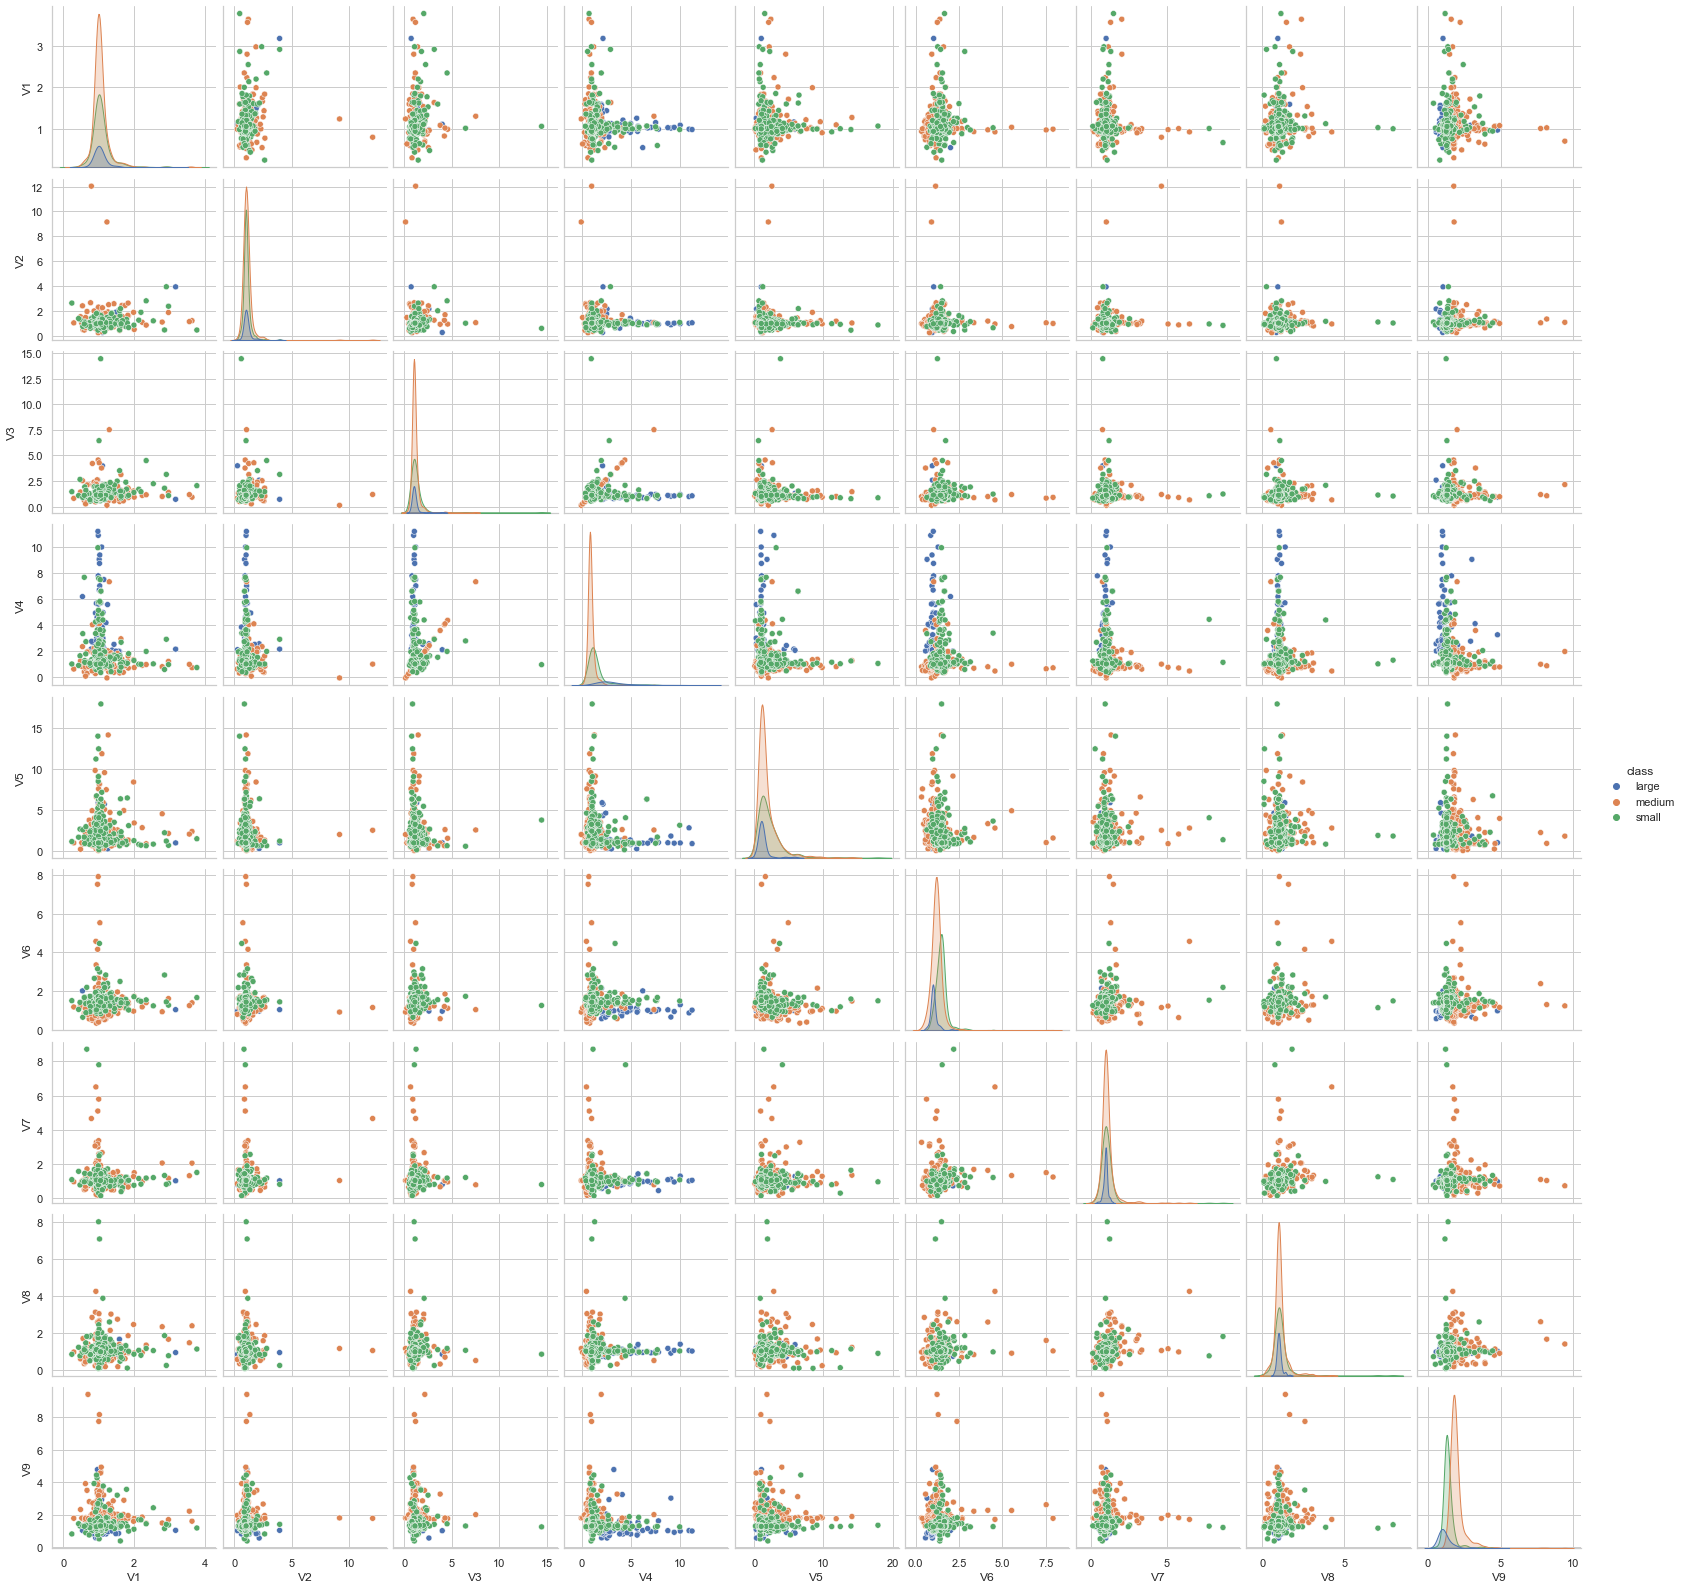

In [ ]:
df2 = df.sort_values(by=['class'], ascending=True)
print(df2.head(3))
print(df2.shape)

plt.figure(dpi=200, figsize=(9, 3))
sns.set(style='whitegrid')

ax = sns.pairplot(hue='class', data=df2)

#  Methods:
<b>Baselines.</b> The extracted features are used to train the  RF, SVMs,  XGBoost, and MLP classifiers. Then we compare the performance of RF, SVMs, XGBoost, and MLP classifiers.
The performance of the classification algorithms used in this study is compared by using training and testing splitting method (holdout method, test_size = 0.2), and cross-validation (K-Fold, n_splits=10).

<b>Metrics.</b> For the comparison of the performance of the four different models, we mainly evaluate performance of the modeling results through common confusion matrix rates like accuracy and F1 Score. 

<b>Optimization and hyperparameters tuning.</b> We optimize our top model (RF) by Grid Search. The main hyperparameters of RF model are determined by grid search method. All the hyperparameter for the RF model was showed in below.

<b>Oversampling with imbalanced dataset.</b> A class imbalance problem arises since the number of negative class instances in the data set is much higher than that of the positive class instances (Fig 2). Therefore, a balanced classifier is needed to increase accuracy of the production rate to the True class. To deal with this class imbalance problem, we use oversampling method with the python “imblearn” package, in which a uniform distribution over the classes is aimed to be achieved by adding more of the minority (positive class in our dataset) class instances. In our project, 20% of the data set consisting of 12,330 samples is first left out for testing and the oversampling method is applied to the remaining 80% of the samples.

# Results:

## Feature ranking
We chose the top 3 features for the later modeling based our feature selection results with the. 

In [ ]:
X = df.drop('class', axis=1)
y = df['class']

In [ ]:
X.head()

V1        V2        V3        V4        V5        V6        V7  \
cell                                                                           
510001  1.008010  0.947239  1.303464  1.103464  0.909373  1.227582  1.166134   
510002  0.629921  0.969547  1.133455  0.933455  1.183153  1.241237  1.214227   
510003  1.032310  0.942243  0.953919  0.994644  1.500366  1.573209  0.936047   
510004  0.484779  1.527135  1.423546  1.223546  0.258842  1.229355  0.784689   
510005  1.008726  0.666702  1.339037  1.139037  1.339623  1.337838  0.984082   

              V8        V9  
cell                        
510001  1.238667  1.815817  
510002  0.719626  1.640061  
510003  0.961773  1.598687  
510004  0.615348  2.320420  
510005  1.475814  2.178210

In [ ]:
y.head()

cell
510001    medium
510002    medium
510003     small
510004    medium
510005    medium
Name: class, dtype: object

In [ ]:
rf = RandomForestClassifier(max_depth=10, random_state=42,
                            n_estimators=300).fit(X, y)

In [ ]:
rf.feature_importances_

array([0.02162183, 0.02199553, 0.06320945, 0.2550663 , 0.03959914,
       0.16532765, 0.02425477, 0.02264133, 0.38628399])

In [ ]:
df.columns

Index(['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'class'], dtype='object')

In [ ]:
feature_rank = pd.DataFrame(rf.feature_importances_,
                            index=df.columns[0:9],
                            columns=['importance'
                                     ]).sort_values('importance',
                                                    ascending=False)
feature_rank.head(10)

importance
V9    0.386284
V4    0.255066
V6    0.165328
V3    0.063209
V5    0.039599
V7    0.024255
V8    0.022641
V2    0.021996
V1    0.021622

In [ ]:
test = SelectKBest(score_func=f_classif, k=4)
fit = test.fit(X, y)
# summarize scores
print(fit.scores_)
features = fit.transform(X)
# summarize selected features
print(features[0:5, :])

[  1.35140133   0.9674751    2.5441925  202.34292048  10.51830634
  32.01942597   1.4407694    0.90901514  98.50737694]
[[1.10346385 0.90937285 1.22758216 1.81581722]
 [0.93345521 1.18315252 1.24123711 1.64006093]
 [0.99464369 1.50036576 1.57320921 1.59868748]
 [1.2235458  0.25884244 1.22935475 2.32042007]
 [1.13903743 1.33962264 1.33783784 2.17821026]]


In [ ]:
feature_rank = pd.DataFrame(fit.scores_,
                            index=df.columns[0:9],
                            columns=['importance'
                                     ]).sort_values('importance',
                                                    ascending=False)
feature_rank.head(10)

importance
V4  202.342920
V9   98.507377
V6   32.019426
V5   10.518306
V3    2.544192
V7    1.440769
V1    1.351401
V2    0.967475
V8    0.909015

In [ ]:
model = LogisticRegression(solver='lbfgs')
rfe = RFE(model, 3)
fit = rfe.fit(X, y)
print("Num Features: %d" % fit.n_features_)
print("Selected Features: %s" % fit.support_)
print("Feature Ranking: %s" % fit.ranking_)

Num Features: 3
Selected Features: [False False False  True False  True False False  True]
Feature Ranking: [6 5 2 1 3 1 4 7 1]


In [ ]:
df.columns[:9][fit.support_]
# fit.support_

Index(['V4', 'V6', 'V9'], dtype='object')

In [ ]:
df_new = df.drop(['V1', 'V2','V3','V7', 'V8'], axis=1)
df_new.head()

V4        V5        V6        V9   class
cell                                                  
510001  1.103464  0.909373  1.227582  1.815817  medium
510002  0.933455  1.183153  1.241237  1.640061  medium
510003  0.994644  1.500366  1.573209  1.598687   small
510004  1.223546  0.258842  1.229355  2.320420  medium
510005  1.139037  1.339623  1.337838  2.178210  medium

In [ ]:
# Group data together
def distplot_feature(feature):
    x1 = df_new[df_new['class'] == 'small'][feature]
    x2 = df_new[df_new['class'] == 'medium'][feature]
    x3 = df_new[df_new['class'] == 'large'][feature]
    hist_data = [x1, x2, x3]
    group_labels = ['Small', 'Medium', 'Large']
    # Create distplot with custom bin_size
    fig = ff.create_distplot(hist_data, group_labels, bin_size=0.2)
    fig.update_layout(
        height=600,
        width=600,
        template='seaborn',
    )
    fig.show()

In [ ]:
distplot_feature('V4')

In [ ]:
distplot_feature('V6')

In [ ]:
distplot_feature('V6')

In [ ]:
distplot_feature('V9')

In [ ]:
X = df_new.drop('class', axis=1)
y = df_new['class']

In [ ]:
pca = PCA(n_components=2)
pca.fit(X)
X_reduced = pca.transform(X)

In [ ]:
components = pd.DataFrame(pca.components_,
                          index=['y_', 'x_'],
                          columns=['V4', 'V5', 'V6', 'V9'])
print(components.head())

          V4        V5        V6        V9
y_ -0.082239  0.996498 -0.003331 -0.014768
x_  0.988594  0.079661 -0.011914 -0.127255


In [ ]:
fig = go.Figure(
    go.Heatmap(z=components, x=['V4', 'V5', 'V6', 'V9'], y=['x_', 'y_']))
fig.update_layout(
    height=600,
    width=600,
    template='seaborn',
)
fig

In [ ]:
X_reduced_df = pd.DataFrame(X_reduced, columns=['x_', 'y_'])
X_reduced_df['class'] = pd.DataFrame(y.values)
print(X_reduced_df.head())

         x_        y_   class
0 -0.986747 -0.385871  medium
1 -0.697394 -0.509928  medium
2 -0.386819 -0.422858   small
3 -1.652332 -0.383215  medium
4 -0.566648 -0.363859  medium


In [ ]:
def reduced_scatter(df):
    cat_codes = X_reduced_df['class'].astype("category").cat.codes
    fig = go.Figure(
        go.Scatter(
            x=X_reduced_df['x_'],
            y=X_reduced_df['y_'],
            mode='markers',
            marker=dict(
                size=4,
                color=cat_codes,  #set color equal to a variable
                colorscale='Inferno',  # one of plotly colorscales
                showscale=True),
            text=X_reduced_df['class']))
    fig.update_layout(
        height=600,
        width=600,
        template='seaborn',
    )
    fig.show()

In [ ]:
reduced_scatter(X_reduced_df)

In [ ]:
X_reduced = TSNE(n_components=2, random_state=42).fit_transform(X)
X_reduced_df = pd.DataFrame(X_reduced, columns=['x_', 'y_'])
X_reduced_df['class'] = pd.DataFrame(y.values)
reduced_scatter(X_reduced_df)

## Classifier

In [ ]:
df_new.head()

V4        V5        V6        V9   class
cell                                                  
510001  1.103464  0.909373  1.227582  1.815817  medium
510002  0.933455  1.183153  1.241237  1.640061  medium
510003  0.994644  1.500366  1.573209  1.598687   small
510004  1.223546  0.258842  1.229355  2.320420  medium
510005  1.139037  1.339623  1.337838  2.178210  medium

In [ ]:
X = df_new.drop('class', axis=1)
y = df_new['class']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42)

In [ ]:
classifiers = {
    'DecisionTreeClassifier': DecisionTreeClassifier(),
    'LogisiticRegression': LogisticRegression(),
    'RandomForestClassifier': RandomForestClassifier(),
    'Support Vector Classifier': SVC(),
    'XGBoost:': xgb.XGBClassifier()
}

In [ ]:
kfold = KFold(n_splits=10, shuffle=True)

In [ ]:
for key, classifier in classifiers.items():
    classifier.fit(X_train, y_train)
    training_score = cross_val_score(classifier,
                                     X_train,
                                     y_train,
                                     scoring='accuracy',
                                     cv=kfold)
    print('Classifiers: ', classifier.__class__.__name__, 'training score:',
          round(training_score.mean(), 2) * 100, '% accuracy score')
    predictions = classifier.predict(X_test)
    print(classification_report(y_test, predictions))

Classifiers:  DecisionTreeClassifier training score: 90.0 % accuracy score
              precision    recall  f1-score   support

       large       0.94      0.94      0.94        18
      medium       0.89      0.91      0.90        89
       small       0.88      0.85      0.87        61

    accuracy                           0.89       168
   macro avg       0.91      0.90      0.90       168
weighted avg       0.89      0.89      0.89       168

Classifiers:  LogisticRegression training score: 87.0 % accuracy score
              precision    recall  f1-score   support

       large       0.75      0.50      0.60        18
      medium       0.86      0.98      0.92        89
       small       0.84      0.75      0.79        61

    accuracy                           0.85       168
   macro avg       0.82      0.74      0.77       168
weighted avg       0.84      0.85      0.84       168

Classifiers:  RandomForestClassifier training score: 93.0 % accuracy score
              pre

In [ ]:
kfold = KFold(n_splits=10, shuffle=True)
skf = StratifiedKFold(n_splits=10, shuffle=True)

In [ ]:
for key, classifier in classifiers.items():
    training_score = cross_val_score(classifier, X, y, cv=skf)
    print('Classifiers: ', classifier.__class__.__name__, 'training score of',
          round(training_score.mean(), 2) * 100, '±',
          round(training_score.std(), 2) * 100, '%')

Classifiers:  DecisionTreeClassifier training score of 88.0 ± 2.0 %
Classifiers:  LogisticRegression training score of 86.0 ± 3.0 %
Classifiers:  RandomForestClassifier training score of 93.0 ± 3.0 %
Classifiers:  SVC training score of 88.0 ± 3.0 %
[13:01:52] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:01:52] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:01:52] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old be

## Grid search

In [ ]:
# Use GridSearchCV to find the best parameters.
# Random Forest
random_forest_params = {
    'n_estimators': [100, 200, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': [1, 5, 10, 50, 100],
    'criterion': ['gini', 'entropy']
}
grid_random_forest = GridSearchCV(RandomForestClassifier(),
                                  random_forest_params)
grid_random_forest.fit(X_train, y_train)
# Random Forest best estimator
random_forest = grid_random_forest.best_estimator_

In [ ]:
grid_random_forest.best_params_

{'criterion': 'gini',
 'max_depth': 50,
 'max_features': 'log2',
 'n_estimators': 100}

In [ ]:
# Overfitting Case
random_forest_score = cross_val_score(random_forest, X, y, cv=skf)
print('RandomForest Classifier Cross Validation Score: ',
      round(training_score.mean(), 2) * 100, '±',
      round(training_score.std(), 2) * 100, '%')

RandomForest Classifier Cross Validation Score:  93.0 ± 2.0 %


In [ ]:
# XGB Classifier
xgb_model = xgb.XGBClassifier()
xgb_params = {
    'n_estimators': [100, 200, 500],
    'colsample_bytree': [0.7, 0.8],
    'max_depth': [15, 20, 25],
    'reg_alpha': [1.1, 1.2, 1.3],
    'reg_lambda': [1.1, 1.2, 1.3],
    'subsample': [0.7, 0.8, 0.9]
}
grid_xgb = GridSearchCV(xgb_model,
                        xgb_params,
                        n_jobs=5,
                        cv=5,
                        scoring='accuracy',
                        verbose=2,
                        refit=True)
grid_xgb.fit(X_train, y_train)
# SVC best estimator
xgb_best = grid_xgb.best_estimator_

Fitting 5 folds for each of 486 candidates, totalling 2430 fits
[13:07:55] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [ ]:
grid_xgb.best_params_

{'colsample_bytree': 0.7,
 'max_depth': 15,
 'n_estimators': 200,
 'reg_alpha': 1.1,
 'reg_lambda': 1.2,
 'subsample': 0.7}

In [ ]:
xgb_score = cross_val_score(xgb_best , X, y, cv=skf)
print('XGBoosting Classifier Cross Validation Score',
      round(xgb_score.mean() * 100, 2).astype(str) + '%')

[13:07:55] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:07:55] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:07:56] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:07:56] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the ol

## Learning curve

In [ ]:
# Let's Plot LogisticRegression Learning Curve
def plot_learning_curve(estimator1,
                        estimator2,
                        X,
                        y,
                        ylim=None,
                        cv=None,
                        n_jobs=1,
                        train_sizes=np.linspace(.1, 1.0, 5)):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 14), sharey=True)
    if ylim is not None:
        plt.ylim(*ylim)
    # First Estimator
    train_sizes, train_scores, test_scores = learning_curve(
        estimator1, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    ax1.fill_between(train_sizes,
                     train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std,
                     alpha=0.1,
                     color='#ff9124')
    ax1.fill_between(train_sizes,
                     test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std,
                     alpha=0.1,
                     color='#2492ff')
    ax1.plot(train_sizes,
             train_scores_mean,
             'o-',
             color='#ff9124',
             label='Training score')
    ax1.plot(train_sizes,
             test_scores_mean,
             'o-',
             color='#2492ff',
             label='Cross-validation score')
    ax1.set_title('RandomForestClassifier Learning Curve', fontsize=14)
    ax1.set_xlabel('Training size (m)')
    ax1.set_ylabel('Score')
    ax1.grid(True)
    ax1.legend(loc='best')

    # Second Estimator
    train_sizes, train_scores, test_scores = learning_curve(
        estimator2, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    ax2.fill_between(train_sizes,
                     train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std,
                     alpha=0.1,
                     color='#ff9124')
    ax2.fill_between(train_sizes,
                     test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std,
                     alpha=0.1,
                     color='#2492ff')
    ax2.plot(train_sizes,
             train_scores_mean,
             'o-',
             color='#ff9124',
             label='Training score')
    ax2.plot(train_sizes,
             test_scores_mean,
             'o-',
             color='#2492ff',
             label='Cross-validation score')
    ax2.set_title('XGBClassifier Learning Curve', fontsize=14)
    ax2.set_xlabel('Training size (m)')
    ax2.set_ylabel('Score')
    ax2.grid(True)
    ax2.legend(loc='best')
    return plt

<module 'matplotlib.pyplot' from 'C:\\Users\\shaoq\\miniconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

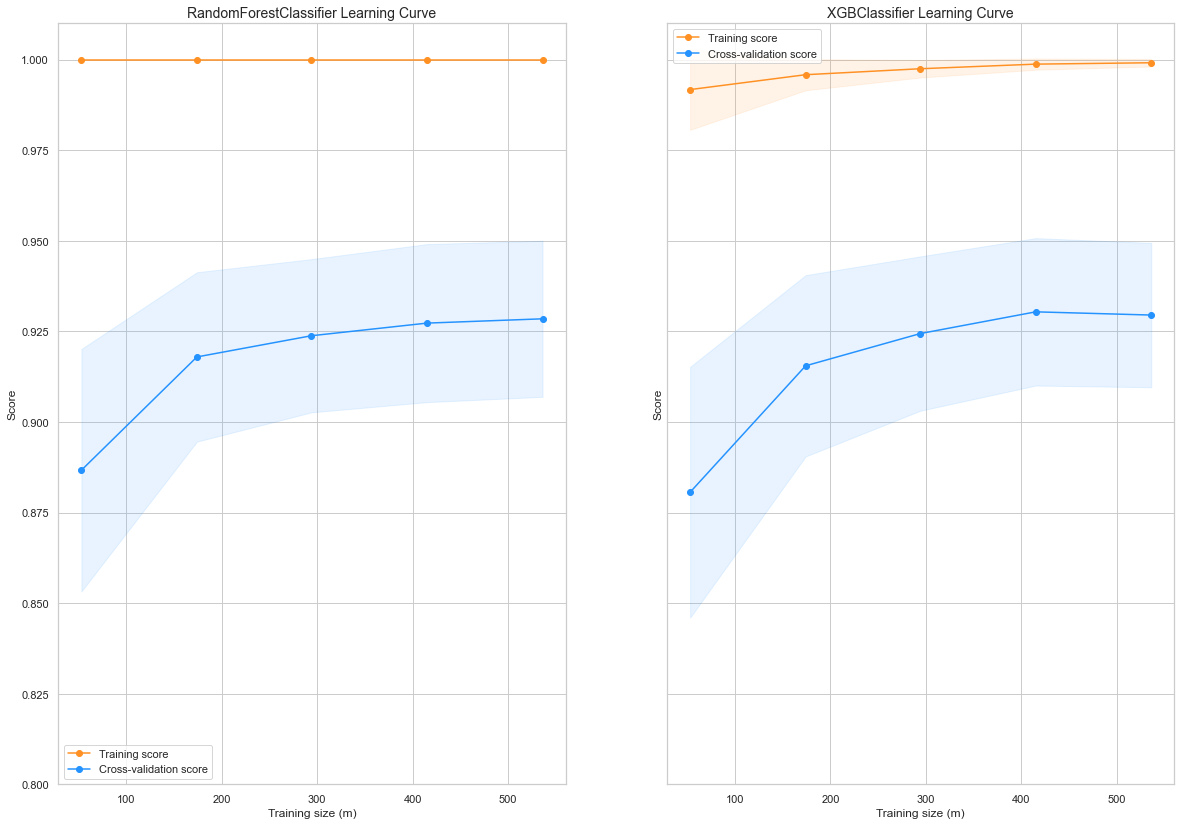

In [ ]:
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=42)
plot_learning_curve(        
                    random_forest,
                    xgb_best,
                    X_train,
                    y_train, (0.8, 1.01),
                    cv=cv,
                    n_jobs=4)

## ROC curve

In [ ]:
X = df.drop(['class', 'V1', 'V2', 'V7', 'V8'], axis=1)
y = df['class']
# print(y)
# Binarize the output
y = label_binarize(y, classes=['small', 'medium', 'large'])
# print(y)
n_classes = y.shape[1]
# print(n_classes)
# shuffle and split training and test sets
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42)
# Learn to predict each class against the other
classifier = OneVsRestClassifier(SVC(probability=True))
y_score = classifier.fit(X_train, y_train).predict_proba(X_test)
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
# Compute micro-average ROC curve and ROC area
fpr['micro'], tpr['micro'], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc['micro'] = auc(fpr['micro'], tpr['micro'])

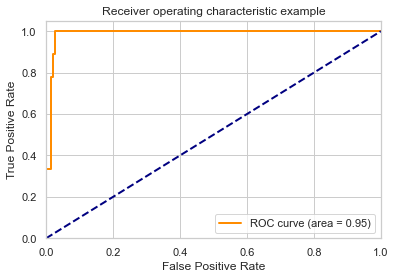

In [ ]:
plt.figure()
lw = 2
plt.plot(fpr[2],
         tpr[2],
         color='darkorange',
         lw=lw,
         label='ROC curve (area = %0.2f)' % roc_auc[1])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc='lower right')
plt.show()

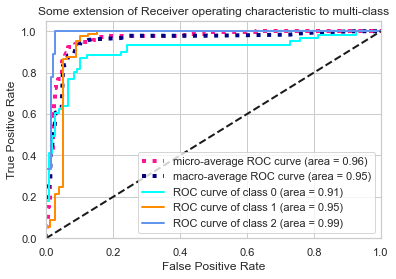

In [ ]:
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr['macro'] = all_fpr
tpr['macro'] = mean_tpr
roc_auc['macro'] = auc(fpr['macro'], tpr['macro'])

# Plot all ROC curves
plt.figure()
plt.plot(fpr['micro'],
         tpr['micro'],
         label='micro-average ROC curve (area = {0:0.2f})'
         ''.format(roc_auc['micro']),
         color='deeppink',
         linestyle=':',
         linewidth=4)

plt.plot(fpr['macro'],
         tpr['macro'],
         label='macro-average ROC curve (area = {0:0.2f})'
         ''.format(roc_auc['macro']),
         color='navy',
         linestyle=':',
         linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i],
             tpr[i],
             color=color,
             lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc='lower right')
plt.show()

## Oversampling and undersampling

In [ ]:
def xgb_grid(X_train, y_train):
    xgb_model = xgb.XGBClassifier()
    xgb_params = {
        'n_estimators': [100, 200, 500],
        'colsample_bytree': [0.7, 0.8],
        'max_depth': [15, 20, 25],
        'reg_alpha': [1.1, 1.2, 1.3],
        'reg_lambda': [1.1, 1.2, 1.3],
        'subsample': [0.7, 0.8, 0.9]
    }
    grid_xgb = GridSearchCV(xgb_model,
                            xgb_params,
                            n_jobs=5,
                            cv=skf,
                            scoring='accuracy',
                            verbose=2,
                            refit=True)
    grid_xgb.fit(X_train, y_train)
    # SVC best estimator
    xgb_best = grid_xgb.best_estimator_
    return xgb_best

In [ ]:
def counter_ratio(y):
    counter = Counter(y)  # summarize distribution
    for k, v in counter.items():
        per = v / len(y) * 100
        print(f'Class={k}, n={v}, ratio={per:.2f}%')

In [ ]:
def heatmap_cm(cm):
    fig = go.Figure(
        go.Heatmap(z=cm,
                   x=['Predict_Large', 'Predict_Medium', 'Predict_Small'],
                   y=['True_Large', 'True_Medium', 'True_Small']))
    fig.update_layout(
        height=600,
        width=600,
        template='seaborn',
    )
    fig.show()

In [ ]:
X = df_new.drop('class', axis=1)
y = df_new['class']

In [ ]:
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in sss.split(X, y):
    print(len(train_index), len(test_index))

671 168


In [ ]:
train_df = df_new.iloc[train_index, :]
train_df = train_df.sample(frac=1) 
print(train_df.head())
counter_ratio(train_df['class'])

              V4        V5        V6        V9   class
cell                                                  
510059  0.947343  0.733033  1.274312  1.368161   small
510195  0.860038  2.678154  1.312508  2.092969  medium
511189  4.043067  1.376129  0.722578  0.906079   large
511025  1.000000  2.749856  1.163090  1.170387   small
510167  0.603030  1.121401  1.188917  2.451901  medium
Class=small, n=233, ratio=34.72%
Class=medium, n=376, ratio=56.04%
Class=large, n=62, ratio=9.24%


In [ ]:
test_df = df_new.iloc[test_index, ]
print(test_df.head())
counter_ratio(test_df['class'])

              V4        V5        V6        V9   class
cell                                                  
511151  0.807044  1.023584  1.073464  1.700616  medium
522086  0.897814  6.345354  1.170689  1.804042  medium
514115  2.064740  0.982029  1.043048  1.907764   large
522092  2.415648  0.397882  1.158377  1.765646  medium
514081  0.808756  1.648430  0.916153  1.671330  medium
Class=medium, n=94, ratio=55.95%
Class=large, n=16, ratio=9.52%
Class=small, n=58, ratio=34.52%


In [ ]:
X_train = train_df.drop('class', axis=1)
y_train = train_df['class']
X_test = test_df.drop('class', axis=1)
y_test = test_df['class']

In [ ]:
classifier = xgb_grid(X_train, y_train)

Fitting 10 folds for each of 486 candidates, totalling 4860 fits
[13:16:24] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [ ]:
predictions = classifier.predict(X_test)
print(accuracy_score(y_test, predictions))
print(classification_report(y_test, predictions))
print(confusion_matrix(y_test, predictions))

0.9226190476190477
              precision    recall  f1-score   support

       large       0.93      0.88      0.90        16
      medium       0.96      0.91      0.93        94
       small       0.87      0.95      0.91        58

    accuracy                           0.92       168
   macro avg       0.92      0.91      0.92       168
weighted avg       0.92      0.92      0.92       168

[[14  1  1]
 [ 1 86  7]
 [ 0  3 55]]


In [ ]:
cm_normal = confusion_matrix(y_test, predictions)

In [ ]:
heatmap_cm(cm_normal)

In [ ]:
for train_index, test_index in sss.split(X, y):
    print(len(train_index), len(test_index))

671 168


In [ ]:
train_df = df_new.iloc[train_index, ]
print(train_df.head())
counter_ratio(train_df['class'])

              V4        V5        V6        V9   class
cell                                                  
514107  1.983148  1.282258  1.047675  0.952392   large
510156  0.663489  1.939208  1.056802  2.128376  medium
510002  0.933455  1.183153  1.241237  1.640061  medium
511091  0.802205  1.151584  0.777567  1.768909  medium
522100  7.324937  2.598007  1.045276  2.004952  medium
Class=large, n=62, ratio=9.24%
Class=medium, n=376, ratio=56.04%
Class=small, n=233, ratio=34.72%


In [ ]:
test_df = df_new.iloc[test_index, ]
print(test_df.head())
counter_ratio(test_df['class'])

              V4        V5        V6        V9   class
cell                                                  
511151  0.807044  1.023584  1.073464  1.700616  medium
522086  0.897814  6.345354  1.170689  1.804042  medium
514115  2.064740  0.982029  1.043048  1.907764   large
522092  2.415648  0.397882  1.158377  1.765646  medium
514081  0.808756  1.648430  0.916153  1.671330  medium
Class=medium, n=94, ratio=55.95%
Class=large, n=16, ratio=9.52%
Class=small, n=58, ratio=34.52%


In [ ]:
train_df = train_df.sample(frac=1)  # amount of large classes 62 rows
small_df = train_df.loc[df['class'] == 'small'][:62]
medium_df = train_df.loc[df['class'] == 'medium'][:62]
large_df = train_df.loc[df['class'] == 'large'][:62]
normal_distributed_df = pd.concat([small_df, medium_df, large_df])

us_train_df = normal_distributed_df.sample(frac=1, random_state=42)
# shuffle dataframe rows
print(us_train_df.head())
counter_ratio(us_train_df['class'])

              V4        V5        V6        V9   class
cell                                                  
523113  0.755090  1.012336  1.259109  2.125845  medium
514110  2.064380  1.140570  0.867648  0.990637   large
514121  1.942278  0.968836  0.995815  0.988645   large
522116  1.170519  1.035559  1.200000  1.808772  medium
514029  1.110533  1.222432  1.157082  1.894305  medium
Class=medium, n=62, ratio=33.33%
Class=large, n=62, ratio=33.33%
Class=small, n=62, ratio=33.33%


In [ ]:
X_train = us_train_df.drop('class', axis=1)
y_train = us_train_df['class']
X_test = test_df.drop('class', axis=1)
y_test = test_df['class']

In [ ]:
classifier = xgb_grid(X_train, y_train)

Fitting 10 folds for each of 486 candidates, totalling 4860 fits
[13:20:36] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [ ]:
predictions = classifier.predict(X_test)
print(accuracy_score(y_test, predictions))
print(classification_report(y_test, predictions))
print(confusion_matrix(y_test, predictions))

0.875
              precision    recall  f1-score   support

       large       0.70      1.00      0.82        16
      medium       0.99      0.80      0.88        94
       small       0.81      0.97      0.88        58

    accuracy                           0.88       168
   macro avg       0.83      0.92      0.86       168
weighted avg       0.90      0.88      0.88       168

[[16  0  0]
 [ 6 75 13]
 [ 1  1 56]]


In [ ]:
cm_undersample = confusion_matrix(y_test, predictions)

In [ ]:
heatmap_cm(cm_undersample)

In [ ]:
X_train = train_df.drop('class', axis=1)
y_train = train_df['class']
X_test = test_df.drop('class', axis=1)
y_test = test_df['class']

In [ ]:
oversample = SMOTE()
X_sm, y_sm = oversample.fit_resample(X_train, y_train)

In [ ]:
counter_ratio(y_sm)

Class=small, n=376, ratio=33.33%
Class=medium, n=376, ratio=33.33%
Class=large, n=376, ratio=33.33%


In [ ]:
classifier = xgb_grid(X_sm, y_sm)

Fitting 10 folds for each of 486 candidates, totalling 4860 fits
[13:30:29] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [ ]:
predictions = classifier.predict(np.array(X_test))
print(accuracy_score(y_test, predictions))
print(classification_report(y_test, predictions))
print(confusion_matrix(y_test, predictions))

0.9047619047619048
              precision    recall  f1-score   support

       large       0.83      0.94      0.88        16
      medium       0.95      0.88      0.92        94
       small       0.86      0.93      0.89        58

    accuracy                           0.90       168
   macro avg       0.88      0.92      0.90       168
weighted avg       0.91      0.90      0.91       168

[[15  1  0]
 [ 2 83  9]
 [ 1  3 54]]


In [ ]:
cm_oversample = confusion_matrix(y_test, predictions)

In [ ]:
heatmap_cm(cm_oversample)

## Neural network

In [ ]:
X = df_new.drop('class', axis=1)
y = df['class']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42)

In [ ]:
classifier = MLPClassifier(hidden_layer_sizes=(100, ),
                           activation='relu',
                           solver='adam',
                           alpha=0.0001,
                           batch_size='auto',
                           learning_rate='constant',
                           learning_rate_init=0.001,
                           power_t=0.5,
                           max_iter=1000,
                           shuffle=True,
                           random_state=None,
                           tol=0.0001,
                           verbose=False,
                           warm_start=False,
                           momentum=0.9,
                           nesterovs_momentum=True,
                           early_stopping=False,
                           validation_fraction=0.1,
                           beta_1=0.9,
                           beta_2=0.999,
                           epsilon=1e-08,
                           n_iter_no_change=10)
# Train the model on the whole data set
classifier.fit(X_train, y_train)

MLPClassifier(max_iter=1000)

In [ ]:
training_score = cross_val_score(classifier, X_train, y_train, cv=skf)
print('Classifiers: training score:',
      round(training_score.mean(), 2) * 100, '% accuracy score')
predictions = classifier.predict(X_test)
print(classification_report(y_test, predictions))

Classifiers: training score: 86.0 % accuracy score
              precision    recall  f1-score   support

       large       0.88      0.83      0.86        18
      medium       0.89      0.94      0.92        89
       small       0.89      0.84      0.86        61

    accuracy                           0.89       168
   macro avg       0.89      0.87      0.88       168
weighted avg       0.89      0.89      0.89       168



In [ ]:
X_train

V4        V5        V6        V9
cell                                          
511052  0.957562  3.457459  1.295002  1.233574
514034  0.943391  0.966830  1.161909  1.875465
514044  0.916139  0.951191  1.082857  1.718522
511151  0.807044  1.023584  1.073464  1.700616
514058  0.756707  0.993405  1.181206  1.780233
...          ...       ...       ...       ...
510072  2.933120  0.917592  1.235982  1.705159
510107  9.050047  1.861190  0.662100  3.022006
511041  0.995671  1.005474  1.488677  1.181171
514012  0.839263  0.989668  1.189173  1.740358
510103  4.822481  0.924251  1.558185  1.878547

[671 rows x 4 columns]

In [ ]:
numerical_train_data = np.stack(X_train.values, 0)
numerical_train_data = torch.tensor(numerical_train_data, dtype=torch.float)

In [ ]:
numerical_test_data = np.stack(X_test.values, 0)
numerical_test_data = torch.tensor(numerical_test_data, dtype=torch.float)

In [ ]:
numerical_train_data, numerical_test_data

(tensor([[0.9576, 3.4575, 1.2950, 1.2336],
         [0.9434, 0.9668, 1.1619, 1.8755],
         [0.9161, 0.9512, 1.0829, 1.7185],
         ...,
         [0.9957, 1.0055, 1.4887, 1.1812],
         [0.8393, 0.9897, 1.1892, 1.7404],
         [4.8225, 0.9243, 1.5582, 1.8785]]),
 tensor([[0.9925, 1.1090, 1.5188, 1.3706],
         [0.8692, 0.9989, 1.3386, 1.8073],
         [0.9706, 4.6111, 1.5484, 1.3310],
         [0.9638, 2.0967, 1.2525, 2.2162],
         [1.1673, 1.1476, 1.2565, 2.2310],
         [0.9941, 1.0053, 1.6122, 1.4754],
         [1.9272, 0.9644, 2.1841, 1.3090],
         [1.0211, 2.8090, 1.1129, 1.3826],
         [0.9708, 1.0498, 1.4683, 1.1662],
         [1.2255, 2.0501, 2.6617, 1.4540],
         [1.3834, 1.3253, 1.1047, 1.1476],
         [0.6921, 2.6808, 0.7099, 1.8390],
         [0.6994, 0.9789, 1.2107, 1.8587],
         [1.1123, 1.1949, 1.6235, 1.6412],
         [7.4879, 0.9879, 1.5257, 1.2389],
         [0.9916, 2.9382, 0.7565, 1.7756],
         [1.3270, 3.7360, 1.3023, 1.27

In [ ]:
print(numerical_train_data.shape)
print(numerical_test_data.shape)
print(len(numerical_train_data))
print(len(numerical_test_data))

torch.Size([671, 4])
torch.Size([168, 4])
671
168


In [ ]:
transdict = {
    'small': 0,
    'medium': 1,
    'large': 2,
}
y_train_new = np.array([transdict[x] for x in y_train])
y_test_new = np.array([transdict[x] for x in y_test])

In [ ]:
train_outputs = torch.tensor(y_train_new, dtype=torch.long).flatten()
test_outputs = torch.tensor(y_test_new, dtype=torch.long).flatten()

In [ ]:
print(len(train_outputs))
print(len(test_outputs))

671
168


In [ ]:
numerical_train_data.shape[1]

4

In [ ]:
class Model(nn.Module):
    def __init__(self, num_numerical_cols, output_size, layers, p=0.4):
        super().__init__()
        self.batch_norm_num = nn.BatchNorm1d(num_numerical_cols)
        all_layers = []
        input_size = num_numerical_cols

        for i in layers:
            all_layers.append(nn.Linear(input_size, i))
            all_layers.append(nn.ReLU(inplace=True))
            all_layers.append(nn.BatchNorm1d(i))
            all_layers.append(nn.Dropout(p))
            input_size = i

        all_layers.append(nn.Linear(layers[-1], output_size))
        self.layers = nn.Sequential(*all_layers)

    def forward(self, x_numerical):
        x_numerical = self.batch_norm_num(x_numerical)
        x = x_numerical
        x = self.layers(x)
        return x

In [ ]:
model = Model(numerical_train_data.shape[1], 3, [1000, 1000, 50], p=0.4)

In [ ]:
print(model)

Model(
  (batch_norm_num): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=4, out_features=1000, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.4, inplace=False)
    (4): Linear(in_features=1000, out_features=1000, bias=True)
    (5): ReLU(inplace=True)
    (6): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.4, inplace=False)
    (8): Linear(in_features=1000, out_features=50, bias=True)
    (9): ReLU(inplace=True)
    (10): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): Dropout(p=0.4, inplace=False)
    (12): Linear(in_features=50, out_features=3, bias=True)
  )
)


In [ ]:
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
model(numerical_train_data)

tensor([[ 0.3685, -0.0691, -0.3605],
        [ 1.0286, -0.5289, -0.9320],
        [-0.0164,  0.4458, -0.1546],
        ...,
        [ 0.4174, -0.7115, -0.1613],
        [ 0.5920, -0.2869,  0.3892],
        [-0.3139,  1.4855, -0.4757]], grad_fn=<AddmmBackward>)

In [ ]:
epochs = 1000
aggregated_losses = []

for i in range(epochs):
    i += 1
    y_pred = model(numerical_train_data)
    single_loss = loss_function(y_pred, train_outputs)
    aggregated_losses.append(single_loss)

    if i % 25 == 1:
        print(f'epoch: {i:3} loss: {single_loss.item():10.8f}')

    optimizer.zero_grad()
    single_loss.backward()
    optimizer.step()

print(f'epoch: {i:3} loss: {single_loss.item():10.10f}')

epoch:   1 loss: 0.06489927
epoch:  26 loss: 0.07674800
epoch:  51 loss: 0.05474679
epoch:  76 loss: 0.06124015
epoch: 101 loss: 0.04557443
epoch: 126 loss: 0.04496498
epoch: 151 loss: 0.03589828
epoch: 176 loss: 0.04316707
epoch: 201 loss: 0.04816280
epoch: 226 loss: 0.04269855
epoch: 251 loss: 0.03401727
epoch: 276 loss: 0.03392638
epoch: 301 loss: 0.02813180
epoch: 326 loss: 0.03245484
epoch: 351 loss: 0.02043489
epoch: 376 loss: 0.03280634
epoch: 401 loss: 0.05172507
epoch: 426 loss: 0.02372460
epoch: 451 loss: 0.02669862
epoch: 476 loss: 0.02370786
epoch: 501 loss: 0.02242792
epoch: 526 loss: 0.02133118
epoch: 551 loss: 0.01389640
epoch: 576 loss: 0.01601737
epoch: 601 loss: 0.01764676
epoch: 626 loss: 0.01951305
epoch: 651 loss: 0.02263726
epoch: 676 loss: 0.02359061
epoch: 701 loss: 0.01705469
epoch: 726 loss: 0.01862135
epoch: 751 loss: 0.02557860
epoch: 776 loss: 0.01011631
epoch: 801 loss: 0.01732134
epoch: 826 loss: 0.02117403
epoch: 851 loss: 0.01532307
epoch: 876 loss: 0.0

In [ ]:
with torch.no_grad():
    y_val = model(numerical_test_data)
    loss = loss_function(y_val, test_outputs)
print(f'Loss: {loss:.8f}')

Loss: 0.81417322


In [ ]:
print(y_val[:5])

tensor([[ 9.7602, -7.4292, -1.7144],
        [-5.1395,  8.4669, -5.0396],
        [ 7.1431, -5.6066, -1.3155],
        [ 1.3601,  3.2019, -2.7840],
        [-6.6680,  8.6002, -3.0260]])


In [ ]:
y_val = np.argmax(y_val, axis=1)

In [ ]:
print(y_val[:5])

tensor([0, 1, 0, 1, 1])


In [ ]:
print(confusion_matrix(test_outputs, y_val))
print(classification_report(test_outputs, y_val))
print(accuracy_score(test_outputs, y_val))

[[50 10  1]
 [ 6 82  1]
 [ 1  1 16]]
              precision    recall  f1-score   support

           0       0.88      0.82      0.85        61
           1       0.88      0.92      0.90        89
           2       0.89      0.89      0.89        18

    accuracy                           0.88       168
   macro avg       0.88      0.88      0.88       168
weighted avg       0.88      0.88      0.88       168

0.8809523809523809


# Discussion:
<a id='classifiers'></a>
In this section we will train four types of classifiers and decide which classifier will be more effective in detecting <b>fraud transactions</b>.  Before we have to split our data into training and testing sets and separate the features from the labels.

## Summary: 

# Conclusion: 
Implementing SMOTE on our imbalanced dataset helped us with the imbalance of our labels (more small cells than large neurons).

# Reference
<li>Hands on Machine Learning with Scikit-Learn & TensorFlow by Aurélien Géron (O'Reilly).</li>
<li>Credit Fraud || Dealing with Imbalanced Datasets by Janio Martinez Bachmann (Kaggle Notebook)</li>